# River Elevation and Cross-Section

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import py3dep
from pynhd import NLDI
from scipy import optimize
from shapely import ops
from shapely.geometry import LineString, Point

We can retrieve elevation profile for tributaries of a given USGS station ID using `PyNHD` and `Py3DEP`. For this purpose, we get the elevation data for points along the tributaries' flowlines every one kilometer. Note that since the distance is in meters we reproject the geospatial data into ESRI:102003.

In [2]:
CRS = "ESRI:102003"

station_id = "01031500"
distance = 1000  # in meters

First, let's get the basin geometry and tributaries for the station.

In [3]:
nldi = NLDI()

basin = nldi.get_basins(station_id)
flw = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="flowlines",
    distance=1000,
)
flw = flw.set_index("nhdplus_comid").to_crs(CRS)

Now, we can compute the number of points along each river segment based on the target 1-km distance.

In [4]:
flw["n_points"] = np.ceil(flw.length / distance).astype("int")
flw_points = [
    (
        n,
        [
            (p[0][0], p[1][0])
            for p in (
                l.interpolate(x, normalized=True).xy for x in np.linspace(0, 1, pts, endpoint=False)
            )
        ],
    )
    for n, l, pts in flw.itertuples(name=None)
]

We use `Py3DEP` to get elevation data for these points.

In [5]:
flw_elevation = [(n, py3dep.elevation_bycoords(pts, CRS)) for n, pts in flw_points]

Now that we have both the coordinates and their elevation data for the points, we can create a new dataframe and plot the results.

In [6]:
points = pd.DataFrame(flw_points).set_index(0)[1].explode()
points = pd.DataFrame([(n, Point(p)) for n, p in points.items()])
points = points.rename(columns={0: "comid", 1: "geometry"}).set_index("comid")
points = gpd.GeoDataFrame(points, crs=CRS)
elevations = pd.DataFrame(flw_elevation).rename(columns={0: "comid", 1: "elevation"})
elevations = elevations.set_index("comid")["elevation"].explode().astype("float")
points["elevation"] = elevations

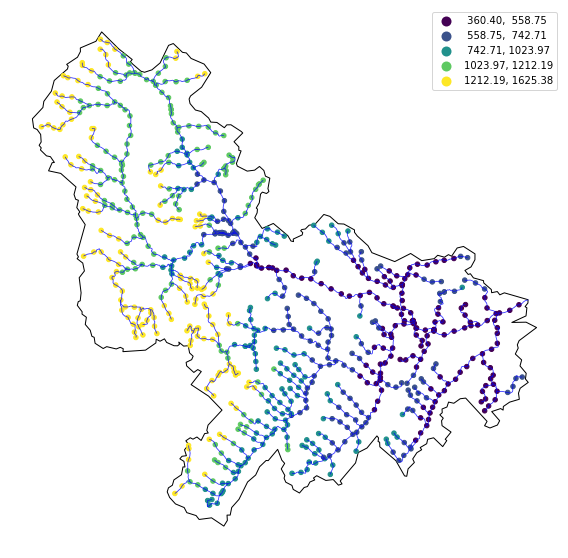

In [7]:
ax = basin.to_crs(CRS).plot(figsize=(10, 10), facecolor="none", edgecolor="black")
points.plot(ax=ax, column="elevation", markersize=20, legend=True, scheme="quantiles")
flw.plot(ax=ax, color="b", linewidth=0.8, alpha=0.8)
ax.set_axis_off()

Let's extract corss-section profiles along the main river of the basin. We get cross-section profiles at every 3 km along the main river and within a buffer distance of 2 km.

In [8]:
distance = 3000  # in meters
width = 2000  # in meters
half_width = width * 0.5

First, we need to get the main river's flowlines.

In [9]:
main = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamMain",
    source="flowlines",
    distance=1000,
)
main = main.set_index("nhdplus_comid").to_crs(CRS)

Now, let's find 2-km line segments that are perpendicular to the main river at the target locations.

In [10]:
def _get_perpendicular(line, half_width):
    xs, ys = line.xy
    (xp2, xp1), (yp2, yp1) = np.array(xs[-2:]), np.array(ys[-2:])
    (x1, x2), (y1, y2) = (0, xp2 - xp1), (0, yp2 - yp1)
    dy, dx = y2 - y1, x2 - x1

    def func(x):
        return [
            (x[0] - x1) * dx + (x[1] - y1) * dy,
            (x[0] - x1) ** 2 + (x[1] - y1) ** 2 - half_width ** 2,
        ]

    x3, y3 = optimize.root(func, [x1 + 1, y1 + 1], method="hybr").x
    x3_left, y3_left = x3 + xp1, y3 + yp1

    x3, y3 = optimize.root(func, [x1 - 1, y1 - 1], method="hybr").x
    x3_right, y3_right = x3 + xp1, y3 + yp1
    return LineString([(x3_left, y3_left), (x3_right, y3_right)])


def get_perpendicular(line, n_segments, half_width):
    segments = np.linspace(0, 1, n_segments, endpoint=False)
    lines = [
        ops.substring(line, s, e, normalized=True) for s, e in zip(segments[:-1], segments[1:])
    ]
    return [_get_perpendicular(line, half_width) for line in lines]


main["n_segments"] = np.ceil(main.length / distance).astype("int") + 1
main_split = [
    (n, get_perpendicular(l, n_seg, half_width)) for n, l, n_seg in main.itertuples(name=None)
]

Let's plot the obtained cross-section lines.

In [11]:
cs = gpd.GeoDataFrame(main_split).rename(columns={0: "comid", 1: "geometry"})
cs = cs.set_index("comid")["geometry"].explode().to_frame()
cs = cs.set_geometry("geometry").set_crs(CRS)

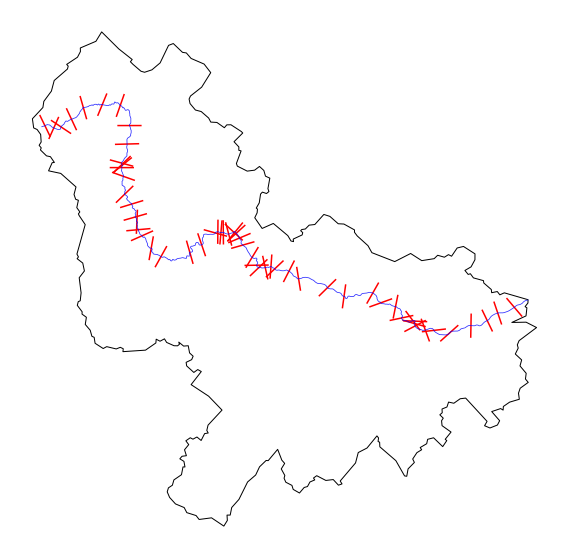

In [12]:
ax = basin.to_crs(CRS).plot(figsize=(10, 10), facecolor="none", edgecolor="black")
cs.plot(ax=ax, color="r")
main.plot(ax=ax, color="b", linewidth=0.8, alpha=0.8)
ax.set_axis_off()

Using the obtained cross-section lines, we can compute the cross-section profiles every 500 meters along the cross-section lines following the same procedure as before.

In [13]:
distance = 500  # in meters
cs["n_points"] = np.ceil(cs.length / distance).astype("int")
cs_points = [
    (
        n,
        [
            (p[0][0], p[1][0])
            for p in (
                l.interpolate(x, normalized=True).xy for x in np.linspace(0, 1, pts, endpoint=False)
            )
        ],
    )
    for n, l, pts in cs.itertuples(name=None)
]
cs_elevation = [(n, py3dep.elevation_bycoords(pts, CRS)) for n, pts in cs_points]

In [14]:
points = pd.DataFrame(cs_points).set_index(0)[1].explode()
points = pd.DataFrame([(n, Point(p)) for n, p in points.items()])
points = points.rename(columns={0: "comid", 1: "geometry"}).set_index("comid")
points = gpd.GeoDataFrame(points, crs=CRS)
elevations = pd.DataFrame(cs_elevation).rename(columns={0: "comid", 1: "elevation"})
elevations = elevations.set_index("comid")["elevation"].explode().astype("float")
points["elevation"] = elevations

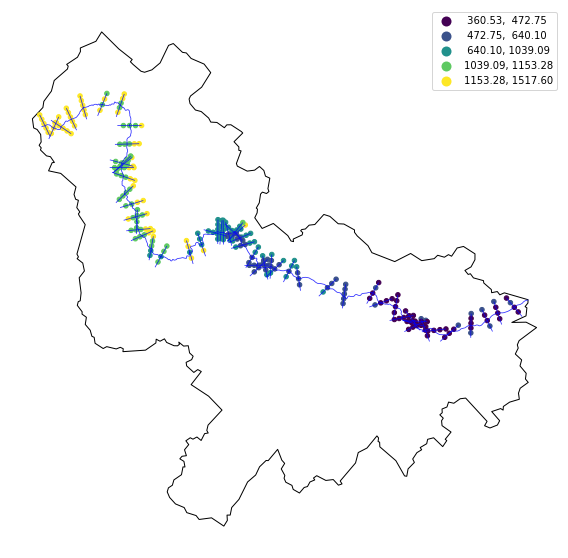

In [15]:
ax = basin.to_crs(CRS).plot(figsize=(10, 10), facecolor="none", edgecolor="black")
main.plot(ax=ax, color="b", linewidth=0.8, alpha=0.8)
points.plot(ax=ax, column="elevation", markersize=20, legend=True, scheme="quantiles")
cs.plot(ax=ax, color="b", linewidth=0.8, alpha=0.8)
ax.set_axis_off()